# State Estimation in a State-space Model (Forward Only)

In this demo, the goal is to filter noisy observations by performing on-line inference with a state-space model (SSM).

We wil use the following model:

\begin{align*}
    u &= 1; v = 200;\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

In this model, we denote by `x_t` the current state of the system (at time step `t`), by `x_t_min` the previous state at time `t-1`, `u` is a constant system input and `y_t` is a noisy observation of `x_t`. We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented by the following Forney-style factor graph, where the pictured section is chained over time:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

For on-line (forward-only) estimation in ForneyLab, it suffices to build a single-time-step section of the model. We then iteratively infer the posterior statistics by considering one observation at a time. After each inference step, we pass the posterior statistics on as the new prior statistics, leading to an (exact) on-line filtering algorithm that is equivalent to Kalman filtering.

We start by generating some data, and then showcase the ForneyLab functionality by walking through the model specification, algorithm generation and execution steps.

In [1]:
# Data
n_samples = 100
x = [t for t=1:n_samples] # True state
y = x + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build the Model

In the model specification phase we define (one time-section of) the generative model. ForneyLab allows for a distributed-as notation `~`, which declares a probabilistic relation between variables. Also the `+` and `*` operators accept variables as arguments, and impose an addition/multiplication constraint on their arguments.

In [2]:
using ForneyLab

g = FactorGraph()

# declare priors as random variables
@RV m_x_t_min # m_x_t_min = Variable(id=:m_x_t_min)
@RV v_x_t_min # v_x_t_min = Variable(id=:v_x_t_min)
@RV x_t_min ~ GaussianMeanVariance(m_x_t_min, v_x_t_min)

# System equations
# u = 1.0; v = 200.0
@RV n_t ~ GaussianMeanVariance(0.0, 200.0)
@RV x_t = x_t_min + 1.0
@RV y_t = x_t + n_t

# Name variable for ease of lookup
#x_t.id = :x_t;

In a simulation, we will want to feed the variable `y_t` with data. Also, we will want to feed the "priors" with the posteriors from the previous time step. We will use a `placeholder()` function to indicate that its argument variable will be clamped to data before the inference procedure.

In [3]:
# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min) # placeholder(:m_x_t_min) does not work
placeholder(v_x_t_min, :v_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t);

ForneyLab offers a `draw()` function that visualizes the factor graph.

In [4]:
ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9711900268225450056 -->
 
 9711900268225450056 
 
 + 
 addition_2 
 
<!-- 9995025740928830612 -->
 
 9995025740928830612 
 
 + 
 addition_1 
 
<!-- 9711900268225450056--9995025740928830612 -->
 
 9711900268225450056--9995025740928830612 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 8294176031237953031 -->
 
 8294176031237953031 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 9711900268225450056--8294176031237953031 -->
 
 9711900268225450056--8294176031237953031 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 2677067305602961667 -->
 
 2677067305602961667 
 
 clamp_3 
 
<!-- 9995025740928830612--2677067305602961667 -->
 
 9995025740928830612--2677067305602961667 
 
 clamp_3 
 1 out 
 3 in2 
 
<!-- 1508181443365504773 -->
 
 1508181443365504773 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 9995025740928830612--1508181443365504773 -->
 
 9995025740928830612--1508181443365504773 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 7273041500680542526 -->
 
 7273041500680542526 
 
 clamp_2 
 
<!-- 8294176031237953031--7273041500680542526 -->
 
 8294176031237953031--7273041500680542526 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 11507662676340157761 -->
 
 11507662676340157761 
 
 clamp_1 
 
<!-- 8294176031237953031--11507662676340157761 -->
 
 8294176031237953031--11507662676340157761 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 15982782970566615945 -->
 
 15982782970566615945 
 
 placeholder_v_x_t_min 
 
<!-- 15982782970566615945--1508181443365504773 -->
 
 15982782970566615945--1508181443365504773 
 
 v_x_t_min 
 3 v 
 1 out 
 
<!-- 4055371347629212737 -->
 
 4055371347629212737 
 
 placeholder_y_t 
 
<!-- 4055371347629212737--9711900268225450056 -->
 
 4055371347629212737--9711900268225450056 
 
 y_t 
 1 out 
 1 out 
 
<!-- 17311441557776628209 -->
 
 17311441557776628209 
 
 placeholder_m_x_t_min 
 
<!-- 17311441557776628209--1508181443365504773 -->
 
 17311441557776628209--1508181443365504773 
 
 m_x_t_min 
 2 m 
 1 out

# Algorithm generation

Now that the factor graph is defined, we can generate a message passing algorithm (MPA) that computes the current state posterior from the  state prior and the current observation. The `sumProductAlgorithm()` function accepts the variables over which the posterior (marginals) are computed and performs two operations:
1. First, it generates a sum-product message-passing schedule (through `sumProductSchedule()`), which is simply an array of message-computation rules that computes the messages for the posterior. 
2. Secondly, it populates fields that are necessary for code generation via `assembleAlgorithm!` call.

After algorithm assembly we can generate Julia source code for our message passing algorithm by calling `algorithmSourceCode` function.

As a side note, the `draw()` function accepts a `schedule` argument. The result of `sumProductSchedule()` may be assigned to this argument, and plots the generated schedule with the factor graph. This functionality could be useful when debugging message passing schedules.

In [5]:
algo = sumProductAlgorithm(x_t) # Figure out a schedule and compile to Julia code
source_code = algorithmSourceCode(algo)
println(source_code)

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=data[:m_x_t_min]), Message(Univariate, PointMass, m=data[:v_x_t_min]))
messages[2] = ruleSPAdditionOutNGP(nothing, messages[1], Message(Univariate, PointMass, m=1.0))
messages[3] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=200.0))
messages[4] = ruleSPAdditionIn1PNG(Message(Univariate, PointMass, m=data[:y_t]), nothing, messages[3])

marginals[:x_t] = messages[2].dist * messages[4].dist

return marginals

end

end # block


The resulting message algorithm `algo` is encoded as a string containing Julia code. In the next cell, we evaluate this code by `eval(parse(algo))`. This step produces the `step!` function that we use to execute the message passing-based inference algorithm. 

In [6]:
# Define algorithm
eval(Meta.parse(source_code));

# Execution

The resulting message algorithm is a string containing Julia code, stored in `algo` (see the output of the previous cell). In the next cell, we evaluate this code so we can actually execute the generated `step!` function, by `eval(parse(algo))`. The `step!` function executes one time step of the inference process. It takes a dictionary with placeholder values (`data`) as input and outputs an array `marginals` that hold the inference results. 

In [7]:
# Define values for prior statistics
m_x_0 = 0.0
v_x_0 = 1000.0

m_x = Vector{Float64}(undef, n_samples)
v_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
v_x_t_min = v_x_0
for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    v_x_t_min = var(marginals[:x_t])
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    v_x[t] = v_x_t_min
end

# Results

That's it. We can now plot the filter output (mean and standard deviation of the state posterior) together with the noisy observations over time.

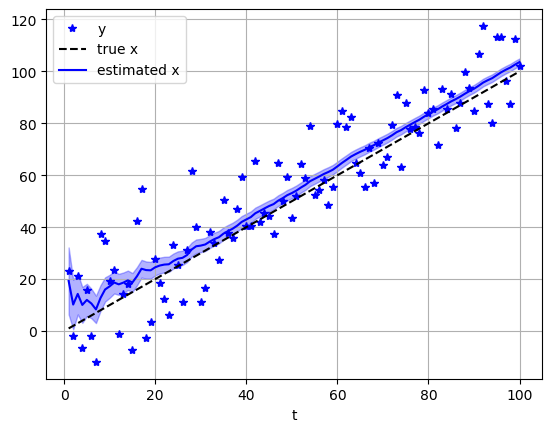

In [8]:
using PyPlot

plot(collect(1:n_samples), y, "b*", label="y")
plot(collect(1:n_samples), x, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");